### Grism_calibrate
#### Create grism calibration files by comparing grism spectra with Jacoby reference spectra

RLM 23 June 2021

In [1]:
import matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io.fits import getdata
import os,sys
import numpy as np

sys.path.insert(0, "..")
from bin.grism_tools_lib import grism_tools

deg = np.pi/180.

do_plot = True

In [2]:
plt.rcParams.update(mpl.rcParamsDefault)
mpl.use('nbAgg')
%matplotlib inline
# ['GTK3Agg', 'GTK3Cairo', 'GTK4Agg', 'GTK4Cairo', 'MacOSX', 'nbAgg', 
# 'QtAgg', 'QtCairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 
# 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']

In [3]:
fts_file = '../images/sample.fts'
im, hdr = getdata(fts_file, 0, header=True)
grism_filter = hdr['FILTER'][0]
star = hdr['OBJECT']
print('Analyzing image %s, grism filter %s' % (fts_file,grism_filter))

# Determine Jacoby reference file name, check for existence
ref_file = '../jacoby_spectra/%s-Jacoby-spec.csv' % star
if os.path.exists(ref_file):
    print('Found Jacoby reference image for star %s' % star)
else:
    print('Cannot find Jacoby reference file %s' % ref_file)

# Instantiate class

G = grism_tools(fts_file,ref_file=ref_file)

image, title, object, utdate, fil, telescope, instrument, z = G.header_params()
print('%s:  %s   %s  %s' % (star,utdate,telescope,instrument))

Analyzing image ../images/sample.fts, grism filter 6
Found Jacoby reference image for star HD44811
HD44811:  2022-03-25 02:43:38   Iowa Robotic Telescope  SBIG Aluma AC4040


Select a subimage near image center to calcualte rotation angle

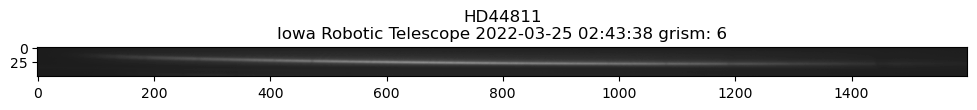

In [4]:
xoff = 100 ; yoff = -400
xw = 800 ; yw = 25  # Adjust by hand

ys,xs = image.shape
xc = int(xs/2) + xoff ; yc = int(ys/2) + yoff
ymin = yc - yw; ymax = yc + yw
xmin = xc - xw; xmax = xc + xw
box = [xmin,xmax,ymin,ymax]

subim = image[ymin:ymax,xmin:xmax]
fig = G.plot_image(im=subim,figsize =(12,6),cmap='gray')

Calculate angle, create subimage using box, set width

In [5]:
ywidth = 50
angle,subim = G.rotate_image(box,ywidth)
print('Rotation = %.1f deg' % angle)

Rotation = 0.4 deg


Plot uncalibrated strip spectrum 

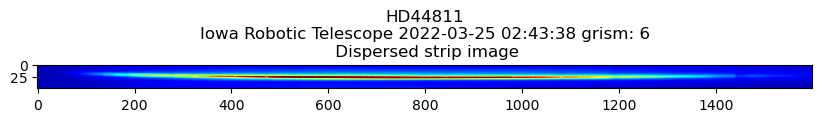

In [6]:
# Plot full image
fig = G.plot_strip()

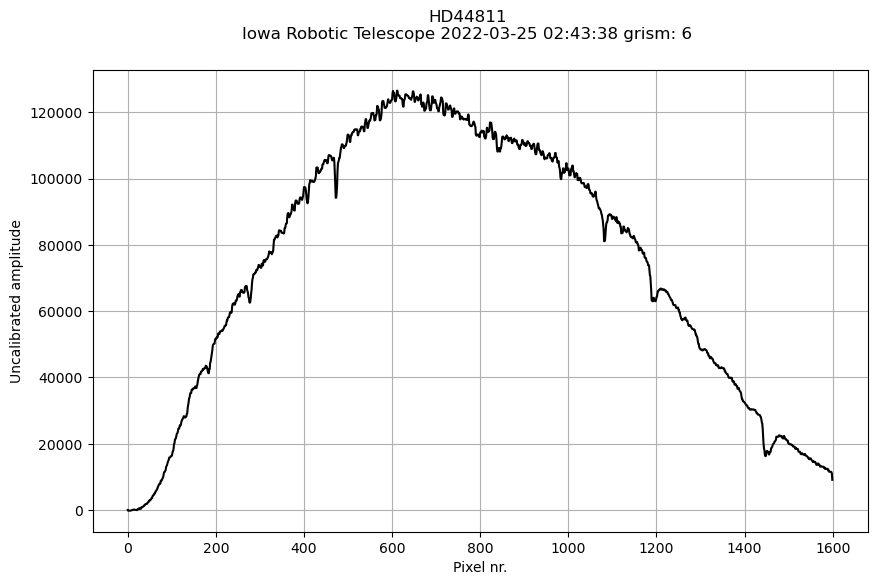

In [7]:
G.calc_spectrum()
fig=G.plot_spectrum(calibrated = False, medavg =3)

Wavelength calibration: Find peaks, compare to Balmer lines to calculate pixel-> wavelength polynomial coeffs

Peaks:    [ 278  472 1082]
Reflines:  [434.05, 486.14, 656.3]


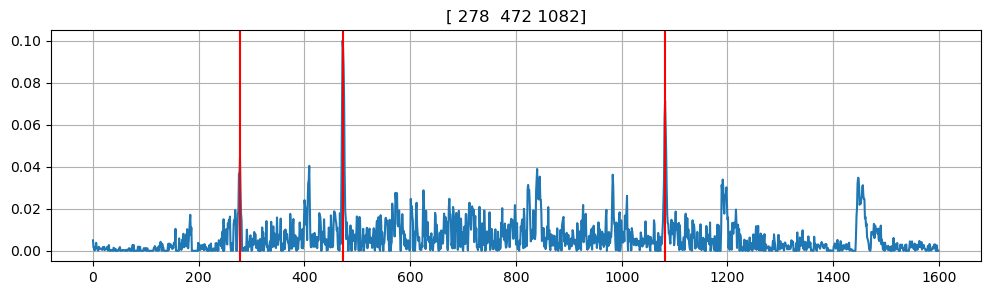

In [8]:
# Adjust manually
prominence = 0.043
peaks, fig = G.find_spectral_peaks(prominence=prominence, do_plot=True)

Halpha = [434.05, 486.14,656.3] # 397.0, 410.17, 
ref_lines = Halpha

# Enter pixel values of peaks that correspond to Balmer lines listed above
peaks = peaks
print ('Peaks:   ',peaks)
print('Reflines: ',ref_lines)

Find coefficients of quadratic fit pixel -> wavelength

In [9]:
f_wave,c = G.calc_wave(peaks,ref_lines)
wavelength_coefficients = c
print ('Wavelength calibration fit coefficients = %.2e,  %.3f,  %.2f' % (c[0],c[1],c[2]))

Wavelength calibration fit coefficients = 1.30e-05,  0.259,  361.11


Clip spectrum arrays to specified wavelength range to ensure it is within Jacoby range (350-744 nm)

In [11]:
# Clip spectrum 
wmin = 400; wmax = 700
wave,raw_spec = G.clip_spectrum(G.wave, G.raw_spec, wmin, wmax)
G.wave = wave; G.raw_spec = raw_spec

Calibrate amplitudes

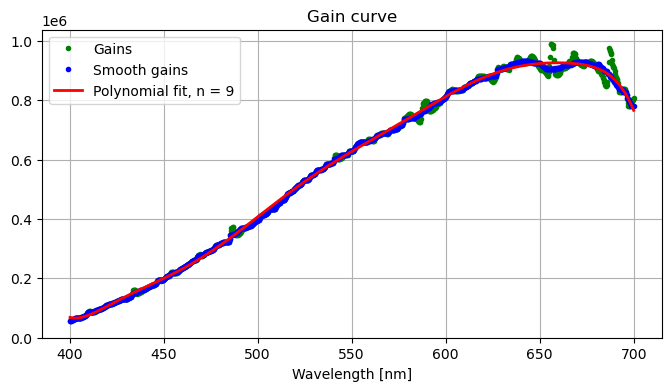

In [12]:
_,gain_curve,fig = G.calc_gain_curve(do_plot = True, do_poly=True, nsmooth=9,npoly=9)

Plot spectrum with wavelength calibrated

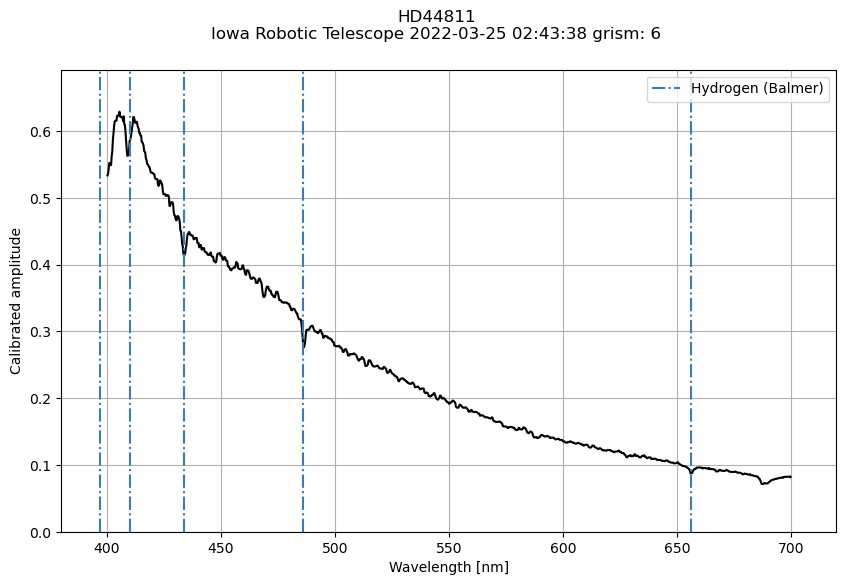

In [14]:
fig=G.plot_spectrum(calibrated = True, medavg =3)

Write calibration information to a calibration file (NB doesn't need to exist)

In [15]:
from datetime import datetime

now = datetime.now()
date = now.strftime("%Y/%m/%d")
cal_file = '../calibrations/grism_cal_%s_%s.csv' % (fil,date.replace('/','_'))

G.write_calib_csv(cal_file, wavelength_coefficients, angle, box, gain_curve)

Wrote calibration file ../calibrations/grism_cal_6_2023_02_06.csv
